# UNet
A UNet consists of both encoder and decoder layers connected by skip connections, which allow information to flow freely between the two. 
Unets are often used for image-to-image tasks, such as image segmentation. Each pixel in an image is converted to another property that is more appropriate for analysis.

## The ssTEM dataset

We will segment different neuronal structures in serial section Transmission Electron Microscopy (ssTEM) images of the ventral nerve cord of the Drosophila melanogaster, a fruit fly. 
The dataset consists of 20 ssTEM images, whose size is 1024 x 1024 pixels. In addition to the ssTEM images, the dataset also contains ground-truth segmentations of the neuronal structures. 
For simplicity, we will only consider the segmentation of the neuronal intracellular regions and mitochondria.

In [1]:
import os

if not os.path.exists("groundtruth-drosophila-vnc"):
    os.system("git clone https://github.com/unidesigner/groundtruth-drosophila-vnc")

raw_path = os.path.join("groundtruth-drosophila-vnc", "stack1", "raw")
label_path = os.path.join("groundtruth-drosophila-vnc", "stack1", "labels")

train_images_paths = os.listdir(raw_path)

print(f"{len(train_images_paths)} training images")

20 training images


We define the data paths for the loaders.

In [2]:
import deeptrack as dt
import torch

#dt.config.disable_image_wrapper()

raw_paths = dt.sources.ImageFolder(root=raw_path)
label_paths = dt.sources.ImageFolder(root=label_path)

paths = dt.sources.Source(raw=raw_paths, label=label_paths)
train_paths, test_paths = dt.sources.random_split(paths, [0.9, 0.1])

train_sources = train_paths.product(
    flip_ud=[True, False],
    flip_lr=[True, False],
    crop=[0, 1, 2],
    should_crop=[True],
)

test_sources = test_paths.constants(
    flip_ud=False,
    flip_lr=False,
    should_crop=False,
)

sources = dt.sources.Sources(train_sources, test_sources)

2024-02-02 13:22:07.128539: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


We will use a function to select only the labels of the cell structures we are interested in, i.e. neuronal intracellular regions and mitochondria.

The function `select_labels` is designed to filter and remap the labels in a segmentation map according to a specified list of class labels. It takes an optional parameter `class_labels` which is a list of labels to be selected from the segmentation map. The function returns an inner function that takes a segmentation map as its input. This inner function first creates a copy of the input segmentation map to avoid modifying the original data. It then generates a mask by selecting pixels that match any of the specified `class_labels` and remaps these selected labels to a new range starting from 1 to the length of `class_labels`. This remapping is achieved using `np.select` which constructs a new segmentation map where each of the specified labels is replaced by its new value. Finally, the function returns a one-hot encoded version of this new segmentation map, where each pixel is represented as a one-hot vector indicating its class, with the vector size being one more than the number of class labels (to account for the background or unspecified labels). This approach is useful for tasks like semantic segmentation in machine learning, where a clear distinction between different classes is required.

In [3]:
import numpy as np

def select_labels(class_labels=None):
    """Create a function to filter and remap labels in a segmentation map."""    
    def inner(segmentation):
        seg = segmentation.copy()
        mask = seg * np.isin(seg, class_labels).astype(np.uint8)
        replace = np.arange(len(class_labels)) + 1
        new_seg = (np.select([mask == c for c in class_labels], replace)
                   .astype(np.uint8))
        return np.eye(len(class_labels) + 1)[new_seg.squeeze()]
    return inner

We define the pipeline to load, crop, and augment the images.

In [4]:
im_pipeline = dt.LoadImage(sources.raw.path) >> dt.NormalizeMinMax()
lab_pipeline = dt.LoadImage(sources.label.path) >> dt.Lambda(
    select_labels, class_labels=[255, 191]
)

pipeline = (
    (im_pipeline & lab_pipeline)
    >> dt.FlipLR(sources.flip_lr)
    >> dt.FlipUD(sources.flip_ud)
    >> dt.ConditionalSetFeature(
        on_true=dt.Crop(crop=(256, 256, None)), condition=sources.should_crop
    )
    >> dt.MoveAxis(2, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float)
)

We create train and test datasets and display a few image crops with the corresponding segmentation. 

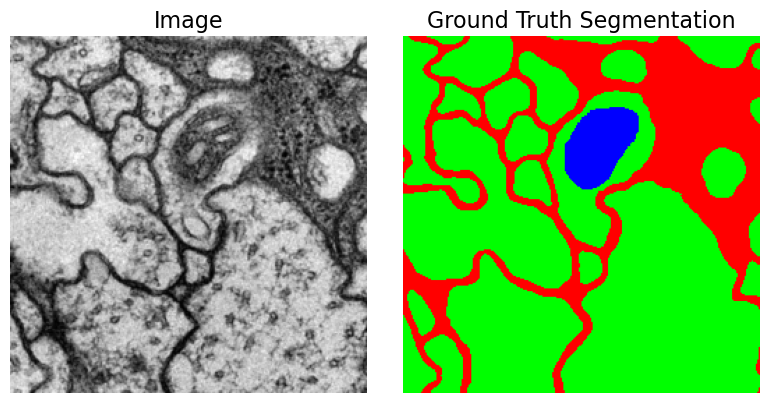

In [35]:
import matplotlib.pyplot as plt

train_dataset = dt.pytorch.Dataset(pipeline, train_sources)

image, label = train_dataset[0]

fig, axs = plt.subplots(1, 2, figsize=((8, 4)))
axs[0].imshow(image.permute(1, 2, 0), cmap="gray")
axs[0].set_title("Image", fontsize=16)
axs[0].set_axis_off()
axs[1].imshow(label.permute(1, 2, 0), cmap="gray")
axs[1].set_title("Ground Truth Segmentation", fontsize=16)
axs[1].set_axis_off()
plt.tight_layout()
plt.show()

We define the dataloaders...

In [10]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

... and the UNet

In [11]:
import deeplay as dl
###from torch.nn import Identity
from torch.nn import CrossEntropyLoss

unet = dl.UNet2d(in_channels=1, channels=[16, 32, 64, 128], out_channels=3)
unet_regressor = dl.Regressor(model=unet, loss=CrossEntropyLoss(),
                              optimizer=dl.Adam()).create()

print(unet)

UNet2d(
  (encoder): ConvolutionalEncoder2d(
    (blocks): LayerList(
      (0): PoolLayerActivationNormalization(
        (pool): Layer[Identity]()
        (layer): Layer[Conv2d](in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
        (normalization): Layer[Identity](num_features=16)
      )
      (1): PoolLayerActivationNormalization(
        (pool): Layer[MaxPool2d](kernel_size=2)
        (layer): Layer[Conv2d](in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
        (normalization): Layer[Identity](num_features=32)
      )
      (2): PoolLayerActivationNormalization(
        (pool): Layer[MaxPool2d](kernel_size=2)
        (layer): Layer[Conv2d](in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
        (normalization): Layer[Identity](num_features=64)
      )
      (3): PoolLayerActivationNormalization(
        (pool):

We train it for 50 epochs

In [12]:
unet_trainer = dl.Trainer(max_epochs=50, accelerator="auto")
unet_trainer.fit(unet_regressor, train_loader)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:452: A layer with UninitializedParameter was found. Thus, the total number of parameters detected may be inaccurate.
INFO: 
  | Name          | Type             | Params

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=50` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


## Evaluation

We apply the UNet to the test set 

In [13]:
test_dataset = dt.pytorch.Dataset(pipeline, test_sources)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

images, labels, preds = [], [], []
for image, label in test_loader:
    images.append(image)
    labels.append(label)
    pr = unet_regressor(image).detach()
    pr = torch.nn.functional.softmax(pr, dim=1)
    preds.append(pr)
images = torch.cat(images, dim=0).squeeze()
labels = torch.cat(labels, dim=0).argmax(axis=1)
preds = torch.cat(preds, dim=0).argmax(axis=1)

We calculate the Jaccard Index, a.k.a. Intersection over Union (IoU) as a metrics to evaluate the results.

In [14]:
from torchmetrics import JaccardIndex

JI = JaccardIndex(task="multiclass", num_classes=3)
ji = [JI(p, l) for p, l in zip(preds, labels)]

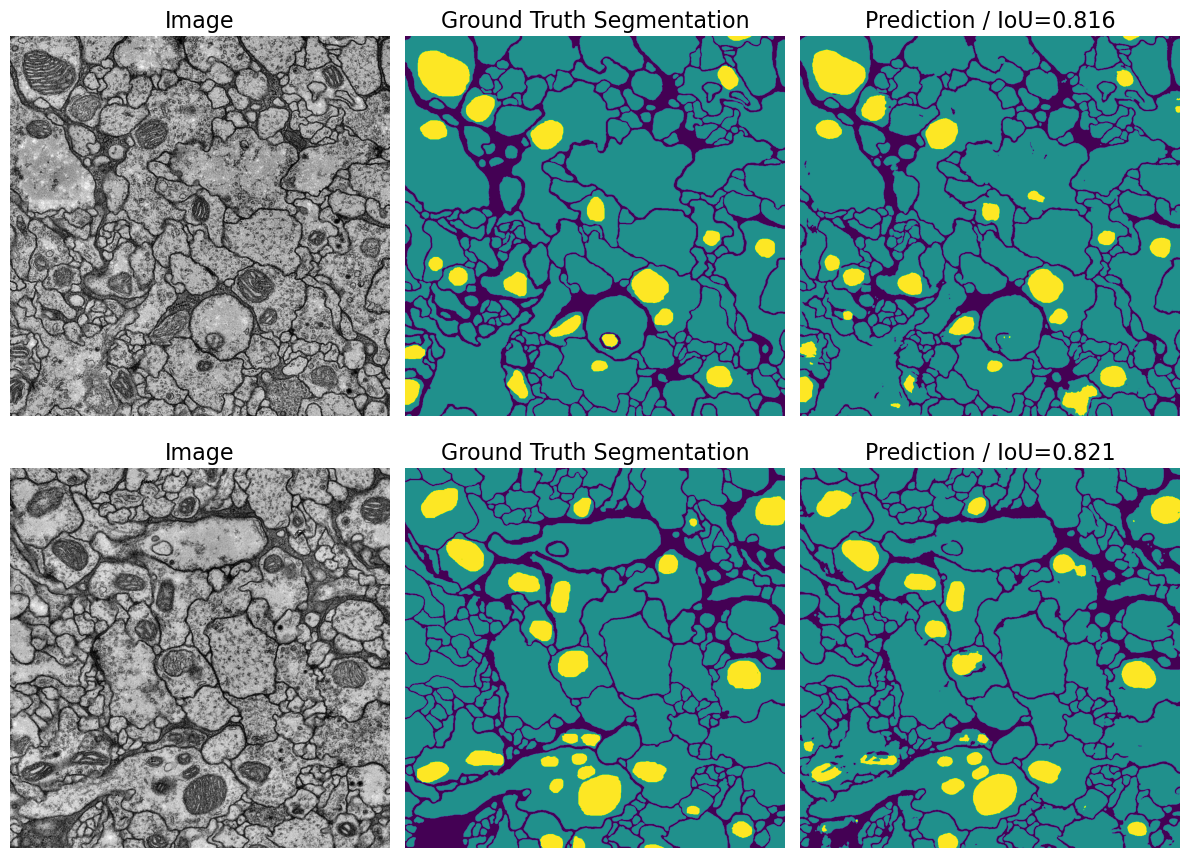

In [38]:
import matplotlib.pyplot as plt

train_dataset = dt.pytorch.Dataset(pipeline, train_sources)

fig, axs = plt.subplots(2, 3, figsize=((12, 9)))
for i in range(2):
    image, label = train_dataset[i]
    axs[i, 0].imshow(images[i], cmap="gray")
    axs[i, 0].set_title("Image", fontsize=16)    
    axs[i, 0].set_axis_off()
    axs[i, 1].imshow(labels[i])
    axs[i, 1].set_title("Ground Truth Segmentation", fontsize=16)
    axs[i, 1].set_axis_off()
    axs[i, 2].imshow(preds[i])
    axs[i, 2].set_title(f"Prediction / IoU={ji[i].numpy():.3f}", fontsize=16)
    axs[i, 2].set_axis_off()    
plt.tight_layout()
plt.show()